In [1]:
from MongoDbUtil import MongoDbUtil
import numpy as np
import datetime
import dateutil
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
utc_tz = dateutil.tz.gettz('UTC')
pst_tz = dateutil.tz.gettz('America/Los_Angeles')

def get_stats(coll, table, start_date, end_date):
    
    last_doc = coll.find().skip(coll.count()-1)[0]
    vals = {}
    timestamps = []
    print("Keys in this table:")
    for key in last_doc[table].keys():
        print(key)
        vals[key] = []

    start_date = start_date.replace(tzinfo=pst_tz).astimezone(utc_tz)
    end_date = end_date.replace(tzinfo=pst_tz).astimezone(utc_tz)
    
    for doc in coll.find({'date': {'$gte': start_date, '$lt': end_date}}, no_cursor_timeout=True):
        timestamps.append(doc['date'].replace(tzinfo=utc_tz).astimezone(pst_tz))
        for key in vals:
            vals[key].append(doc[table][key])
        
    return timestamps, vals

In [7]:
axis_fontsize = 16
legend_fontsize = 16

def draw(ax, timestamps, data, label=None):
    plt.plot_date(timestamps, data, '-', label=label, linewidth=1.5);
    
    ax.set_xlim(timestamps[0] , timestamps[-1])

    ax.xaxis.set_major_locator(DayLocator())
    #ax.xaxis.set_minor_locator(HourLocator(np.arange(0, 25, 2)))
    ax.xaxis.set_major_formatter(DateFormatter('%b/%d-%H:%M', tz=pst_tz))
    fig.autofmt_xdate()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

In [4]:
database = MongoDbUtil(db_name='STARProdState').database()                                                             
jobs_validator_coll = database['jobs_validator_P17idx']
buffers_cleaner_coll = database['buffers_cleaner_P17idx']
daq_watcher_coll = database['daq_files_watcher_P17idx']

### Entire production

Keys in this table:
running
total_in_queue
pending
running_bfc
completing
unknown


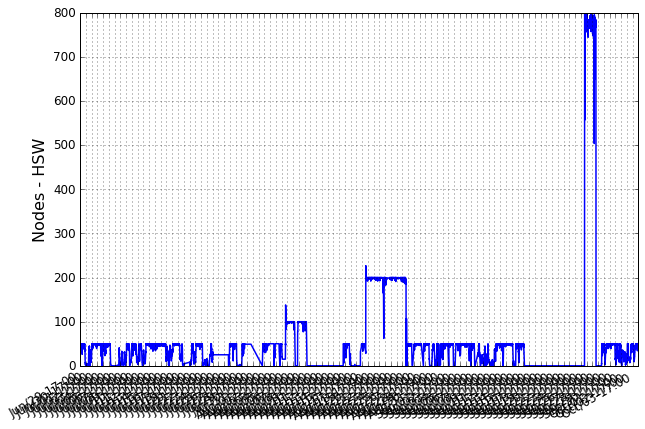

In [8]:
start_dt = datetime.datetime(2017, 6, 29, 0, 0, 0, 0)
end_dt = datetime.datetime.now()

job_stats = get_stats(jobs_validator_coll, table='stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
draw(ax, job_stats[0], job_stats[1]['running'])

plt.ylabel('Nodes - HSW', fontsize=axis_fontsize)
plt.show()

In [6]:
job_accum_stats = get_stats(jobs_validator_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
job_accum_stats[1]['completed_muDst'] = [x - job_accum_stats[1]['completed_muDst'][0] for x in job_accum_stats[1]['completed_muDst']]
job_accum_stats[1]['timeout_job'] = [x - job_accum_stats[1]['timeout_job'][0] for x in job_accum_stats[1]['timeout_job']]

draw(ax, job_accum_stats[0], job_accum_stats[1]['completed_muDst'], label='Completed')
draw(ax, job_accum_stats[0], job_accum_stats[1]['timeout_job'], label='Timeout')

plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.ylabel('#Jobs', fontsize=axis_fontsize);

Keys in this table:
completed_job
failed_muDst
completed_muDst
failed_job
timeout_job


RuntimeError: RRuleLocator estimated to generate 2327 ticks from 2017-06-29 22:48:27.735995+00:00 to 2017-10-04 21:56:32.805998+00:00: exceeds Locator.MAXTICKS * 2 (2000) 

### Reservation 1
100 nodes - 4 days  
Aug/4 8am - Aug/8 8am

In [17]:
start_date = datetime.datetime(2017, 8, 4, 8, 0, 0, 0)
end_date = datetime.datetime(2017, 8, 8, 8, 0, 0, 0)

data_res1 = get_stats(jobs_validator_coll, table='stats', start_date=start_date, end_date=end_date)

Keys in this table:
total_in_queue
completing
running_bfc
unknown
pending
running


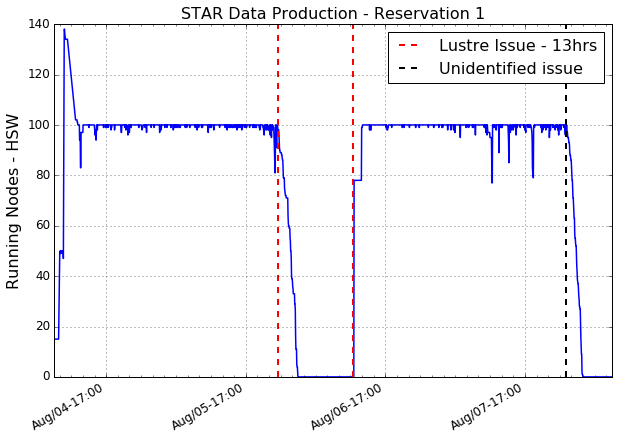

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
draw(ax, data_res1[0], data_res1[1]['running'])
plt.axvline(datetime.datetime(2017,8,5,22,30,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', label='Lustre Issue - 13hrs', linewidth=2)
plt.axvline(datetime.datetime(2017,8,6,11,30,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)
plt.axvline(datetime.datetime(2017,8,8,0,0,0,0).replace(tzinfo=pst_tz),c='k', linestyle='--', linewidth=2, label='Unidentified issue')

plt.ylabel('Running Nodes - HSW', fontsize=axis_fontsize)
plt.legend(loc=0, fontsize=legend_fontsize)
plt.title('STAR Data Production - Reservation 1', fontsize=legend_fontsize)
plt.savefig('nodes_res1.png')

In [19]:
job_accum_stats_res1 = get_stats(jobs_validator_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

Keys in this table:
timeout_job
failed_muDst
completed_job
failed_job
completed_muDst


In [20]:
fig, ax = plt.subplots(figsize=(10,7))
job_accum_stats_res1[1]['completed_muDst'] = [x - job_accum_stats_res1[1]['completed_muDst'][0] for x in job_accum_stats_res1[1]['completed_muDst']]
job_accum_stats_res1[1]['timeout_job'] = [x - job_accum_stats_res1[1]['timeout_job'][0] for x in job_accum_stats_res1[1]['timeout_job']]

draw(ax, job_accum_stats_res1[0], job_accum_stats_res1[1]['completed_muDst'], label='Completed')
draw(ax, job_accum_stats_res1[0], job_accum_stats_res1[1]['timeout_job'], label='Timeout')
plt.axvline(datetime.datetime(2017,8,5,22,30,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', label='Lustre Issue - 13hrs', linewidth=2)
plt.axvline(datetime.datetime(2017,8,6,11,30,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)

plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.title('STAR Data Production - Reservation 1', fontsize=legend_fontsize)
plt.ylabel('#Jobs', fontsize=axis_fontsize);
plt.savefig('jobs_res1.png')

RuntimeError: RRuleLocator estimated to generate 2104 ticks from 2017-06-29 22:48:27.735995+00:00 to 2017-09-25 14:57:05.549004+00:00: exceeds Locator.MAXTICKS * 2 (2000) 

RuntimeError: RRuleLocator estimated to generate 2104 ticks from 2017-06-29 22:48:27.735995+00:00 to 2017-09-25 14:57:05.549004+00:00: exceeds Locator.MAXTICKS * 2 (2000) 

### Reservation 2
200 nodes - 7 days  
Aug/18 8am - Aug/25 8am

In [ ]:
start_dt = datetime.datetime(2017, 8, 18, 8, 0, 0, 0)
#end_dt = datetime.datetime.now()
end_dt = datetime.datetime(2017, 8, 25, 8, 0, 0, 0)

job_stats_res2 = get_stats(jobs_validator_coll, table='stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
draw(ax, job_stats_res2[0], job_stats_res2[1]['running'])
plt.axvline(datetime.datetime(2017,8,21,8,20,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', label='Special partition down -- ~2.5hrs', linewidth=2)
plt.axvline(datetime.datetime(2017,8,21,11,10,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)
plt.axvline(datetime.datetime(2017,8,21,18,50,0,0).replace(tzinfo=pst_tz),c='g', linestyle='--', linewidth=2, label='1 reserved node down - ~16hrs')
plt.axvline(datetime.datetime(2017,8,22,11,20,0,0).replace(tzinfo=pst_tz),c='g', linestyle='--', linewidth=2)

efficiency = 100*np.mean(job_stats_res2[1]['running'])/200.
print(efficiency)
#plt.text(2, 30, "Efficiency", fontsize=15)

#plt.ylim(180,210)
plt.ylabel('Running Nodes - HSW', fontsize=axis_fontsize)
plt.title('STAR Data Production - Reservation 2', fontsize=legend_fontsize)
plt.legend(loc=3, fontsize=legend_fontsize)
plt.savefig('nodes_res2.png')

In [ ]:
job_accum_stats = get_stats(jobs_validator_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
job_accum_stats[1]['completed_muDst'] = [x - job_accum_stats[1]['completed_muDst'][0] for x in job_accum_stats[1]['completed_muDst']]
job_accum_stats[1]['timeout_job'] = [x - job_accum_stats[1]['timeout_job'][0] for x in job_accum_stats[1]['timeout_job']]

draw(ax, job_accum_stats[0], job_accum_stats[1]['completed_muDst'], label='Completed')
draw(ax, job_accum_stats[0], job_accum_stats[1]['timeout_job'], label='Timeout')

#plt.axvline(datetime.datetime(2017,8,21,8,20,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', label='Special partition down -- ~2.5hrs', linewidth=2)
#plt.axvline(datetime.datetime(2017,8,21,11,10,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)

plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.ylabel('#Jobs', fontsize=axis_fontsize);
plt.title('STAR Data Production - Reservation 2', fontsize=legend_fontsize);

In [ ]:
buffer_accum_stats = get_stats(buffers_cleaner_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
buffer_accum_stats[1]['cleaned_prod'] = [x - buffer_accum_stats[1]['cleaned_prod'][0] for x in buffer_accum_stats[1]['cleaned_prod']]

draw(ax, buffer_accum_stats[0], buffer_accum_stats[1]['cleaned_prod'], label='Completed')

#plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.ylabel('#Completed Jobs', fontsize=axis_fontsize);
plt.title('STAR Data Production - Reservation 2', fontsize=legend_fontsize);
plt.savefig('jobs_res2.png')

### File transfers for reservation 3

Keys in this table:
total_files_seen
19131


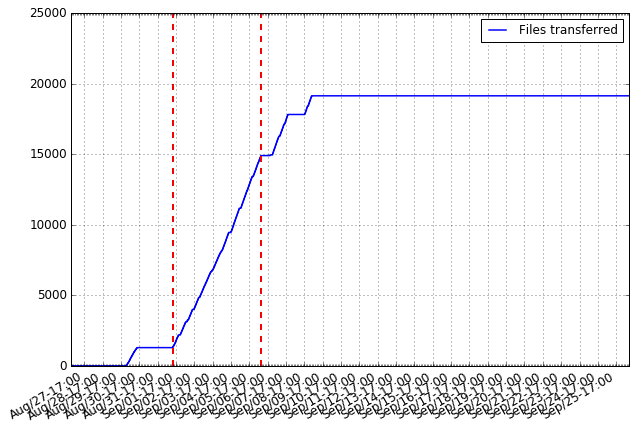

In [5]:
#start_dt = datetime.datetime(2017, 9, 1, 12, 0, 0, 0)
#end_dt = datetime.datetime(2017, 9, 6, 9, 0, 0, 0)
start_dt = datetime.datetime(2017, 8, 27, 0, 0, 0, 0)
end_dt = datetime.datetime.now()

daqs_accum_stats = get_stats(daq_watcher_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)
daqs_accum_stats[1]['total_files_seen'] = [x - daqs_accum_stats[1]['total_files_seen'][0] for x in daqs_accum_stats[1]['total_files_seen']]

fig, ax = plt.subplots(figsize=(10,7))
draw(ax, daqs_accum_stats[0], daqs_accum_stats[1]['total_files_seen'], label='Files transferred')
plt.axvline(datetime.datetime(2017,9,1,13,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)
plt.axvline(datetime.datetime(2017,9,6,8,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)

print(daqs_accum_stats[1]['total_files_seen'][-1])
plt.ylim(0,25000)
plt.legend();

### Reservation 3
800 nodes - 2 days  
Sep/25 8am - Sep/27 8am

Keys in this table:
total_in_queue
pending
running
completing
running_bfc
unknown
97.6415267576


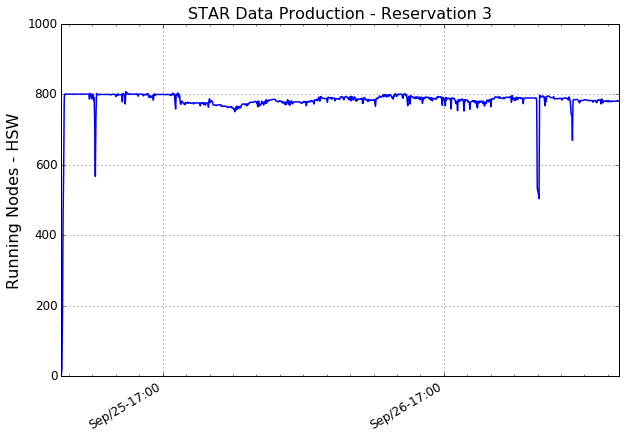

In [92]:
start_dt = datetime.datetime(2017, 9, 25, 8, 20, 0, 0)
#end_dt = datetime.datetime.now()
end_dt = datetime.datetime(2017, 9, 27, 8, 0, 0, 0)

job_stats_res2 = get_stats(jobs_validator_coll, table='stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
tot = [sum(x) for x in zip(job_stats_res2[1]['completing'], job_stats_res2[1]['running'], job_stats_res2[1]['unknown'])]
draw(ax, job_stats_res2[0], tot)

efficiency = 100*np.mean(job_stats_res2[1]['running'])/800.
efficiency = 100*np.mean(tot)/800.
print(efficiency)
#plt.text(2, 30, "Efficiency", fontsize=15)

plt.ylim(0,1000)
plt.ylabel('Running Nodes - HSW', fontsize=axis_fontsize)
plt.title('STAR Data Production - Reservation 3', fontsize=legend_fontsize)
#plt.legend(loc=3, fontsize=legend_fontsize)
plt.savefig('nodes_res3.png')

Keys in this table:
failed_job
completed_muDst
timeout_job
failed_muDst
completed_job


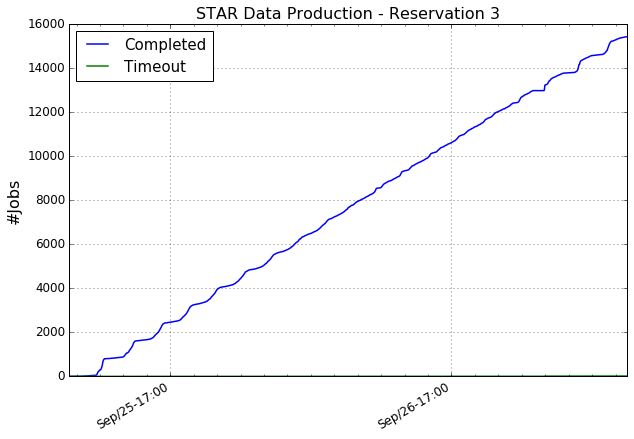

In [90]:
job_accum_stats = get_stats(jobs_validator_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
job_accum_stats[1]['completed_muDst'] = [x - job_accum_stats[1]['completed_muDst'][0] for x in job_accum_stats[1]['completed_muDst']]
job_accum_stats[1]['timeout_job'] = [x - job_accum_stats[1]['timeout_job'][0] for x in job_accum_stats[1]['timeout_job']]

draw(ax, job_accum_stats[0], job_accum_stats[1]['completed_muDst'], label='Completed')
draw(ax, job_accum_stats[0], job_accum_stats[1]['timeout_job'], label='Timeout')

#plt.axvline(datetime.datetime(2017,8,21,8,20,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', label='Special partition down -- ~2.5hrs', linewidth=2)
#plt.axvline(datetime.datetime(2017,8,21,11,10,0,0).replace(tzinfo=pst_tz),c='r', linestyle='--', linewidth=2)

plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.ylabel('#Jobs', fontsize=axis_fontsize);
plt.title('STAR Data Production - Reservation 3', fontsize=legend_fontsize);

Keys in this table:
cleaned_prod


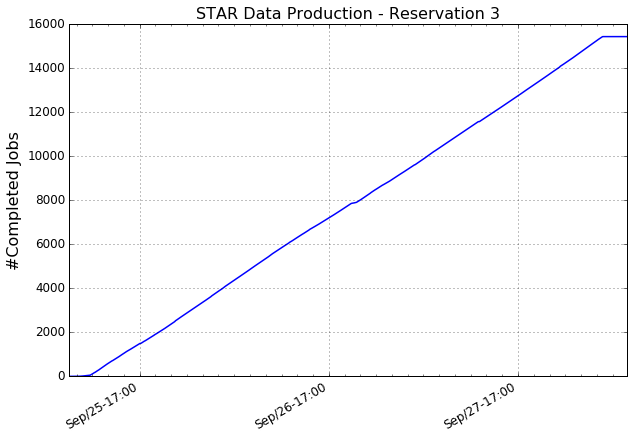

In [85]:
buffer_accum_stats = get_stats(buffers_cleaner_coll, table='accum_stats', start_date=start_dt, end_date=end_dt)

fig, ax = plt.subplots(figsize=(10,7))
buffer_accum_stats[1]['cleaned_prod'] = [x - buffer_accum_stats[1]['cleaned_prod'][0] for x in buffer_accum_stats[1]['cleaned_prod']]

draw(ax, buffer_accum_stats[0], buffer_accum_stats[1]['cleaned_prod'], label='Completed')

#plt.legend(loc=0, fontsize=legend_fontsize-1)
plt.ylabel('#Completed Jobs', fontsize=axis_fontsize);
plt.title('STAR Data Production - Reservation 3', fontsize=legend_fontsize);
plt.savefig('jobs_res3.png')